In [1]:
import gym
import gym_example
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Adversary example: longest path between agent and goal

This notebook trains the adversary to create the longest path possible between agent and goal. Only one wall is used. Grid size 38x38 in adversarial-v2 reward is set to: self.reward = self.shortest_path_length - 20.

## Checking that everything works

In [2]:
env = gym.make("adversarial-v1")

In [3]:
def visualize(state):
    fig = plt.imshow(state, cmap=plt.get_cmap('Accent'))
    # values
    values = np.array([0, 1, 2, 3])
    #items
    items = ['Arena', 'Agent', 'Goal', 'Wall']
    # colormap used by imshow
    colors = [fig.cmap(fig.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.grid(False)
    plt.show()

In [4]:
def run_one_episode(env, verbose=False):
    env.reset()
    sum_reward = 0

    for i in range(env.MAX_STEPS+1):
        action = env.action_space.sample()
        if verbose:
            print("action:", action)
        state, reward, done, info = env.step(action)
        sum_reward += reward

        if verbose:
            env.render()

        if done:
            if verbose:
                print("done @ step {}".format(i))
            break

    if verbose:
        print("cumulative reward", sum_reward)

    return sum_reward

Sum reward:  13


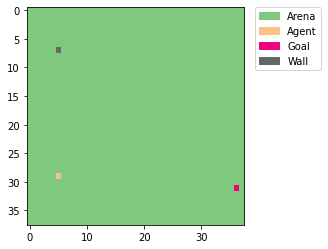

In [5]:
env = gym.make("adversarial-v1")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

#visualize(env.state) --> if adversarial_v0

visualize(env.image_space) 

In [6]:
env = gym.make("adversarial-v1")
env.step(0)
env.step(0)

({'image': array([[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'time_step': [2]},
 0,
 False,
 {})

In [7]:
history = []

for _ in range(20):
    sum_reward = run_one_episode(env, verbose=False)
    history.append(sum_reward)

avg_sum_reward = sum(history) / len(history)
print("\nbaseline cumulative reward: {:6.2}".format(avg_sum_reward))


baseline cumulative reward:    7.5


In [8]:
history

[12, 7, 1, 12, 12, 26, 17, 3, 14, -14, 16, 1, 1, 10, 12, -11, -8, 24, 9, 7]

In [9]:
env.image_space.shape

(38, 38)

# Train

Initialize the directory in which to save checkpoints (i.e., serialize a policy to disk) as a subdirectory ./tmp/exa and also the directory in which to write the logs which Ray expects to be at ~/ray_results/ by default:

In [10]:
import os
import shutil

chkpt_root = "tmp/exa"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

We’ll start Ray running in local mode, i.e., not running on a remote cluster:

In [11]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-04-02 17:03:30,880	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.48',
 'raylet_ip_address': '192.168.1.48',
 'redis_address': '192.168.1.48:6379',
 'object_store_address': '/tmp/ray/session_2021-04-02_17-03-30_355255_44290/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-02_17-03-30_355255_44290/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-02_17-03-30_355255_44290',
 'metrics_export_port': 63930,
 'node_id': '3fd35a0769fd83b0076419166ac11af33c3c2c7afb2adf00bfff257c'}

Register our environment

In [12]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v1 import Adversarial_v1

select_env = "adversarial-v1"
register_env(select_env, lambda config: Adversarial_v1())

Next we’ll configure the environment to use proximal policy optimization (PPO) and create an agent to train using RLlib:

In [13]:
import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

Instructions for updating:
non-resource variables are not supported in the long term


2021-04-02 17:03:36,808	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-04-02 17:03:36,809	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-04-02 17:03:36,899	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2021-04-02 17:03:37,993	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-02 17:03:38,972	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-02 17:03:41,759	WARNING util.py:47 -- Install gputil for GPU system monitoring.


In [14]:
ppo.DEFAULT_CONFIG

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'num_framestacks': 'auto',
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_actio

For each iteration, we call result = agent.train() to run the episodes, and then call chkpt_file = agent.save(chkpt_root) to save a checkpoint of the latest policy. Then we print metrics that show how well the learning has progressed. The resulting output should look close to the following:

In [15]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 100
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
 1 reward -19.00/  4.40/ 49.00 len 4.00 saved tmp/exa/checkpoint_1/checkpoint-1
 2 reward -19.00/  5.50/ 52.00 len 4.00 saved tmp/exa/checkpoint_2/checkpoint-2
 3 reward -19.00/  5.89/ 47.00 len 4.00 saved tmp/exa/checkpoint_3/checkpoint-3
 4 reward -19.00/  6.02/ 48.00 len 4.00 saved tmp/exa/checkpoint_4/checkpoint-4
 5 reward -19.00/  7.30/ 47.00 len 4.00 saved tmp/exa/checkpoint_5/checkpoint-5
 6 reward -19.00/  7.31/ 46.00 len 4.00 saved tmp/exa/checkpoint_6/checkpoint-6
 7 reward -19.00/  7.61/ 49.00 len 4.00 saved tmp/exa/checkpoint_7/checkpoint-7
 8 reward -19.00/  8.28/ 47.00 len 4.00 saved tmp/exa/checkpoint_8/checkpoint-8
 9 reward -19.00/  8.14/ 49.00 len 4.00 saved tmp/exa/checkpoint_9/checkpoint-9
10 reward -19.00/  9.28/ 50.00 len 4.00 saved tmp/exa/checkpoint_10/checkpoint-10
11 reward -19.00/  9.40/ 52.00 len 4.00 saved tmp/exa/checkpoint_11/checkpoint-11
12 reward -19.00/ 10.13/ 50.

98 reward  52.00/ 54.00/ 54.00 len 4.00 saved tmp/exa/checkpoint_98/checkpoint-98
99 reward  54.00/ 54.00/ 54.00 len 4.00 saved tmp/exa/checkpoint_99/checkpoint-99
100 reward  54.00/ 54.00/ 54.00 len 4.00 saved tmp/exa/checkpoint_100/checkpoint-100


In [ ]:
tensorboard --logdir=$HOME/ray_results

# Apply a trained policy in a rollout

In [16]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_100/checkpoint-100'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

2021-04-02 20:51:17,398	INFO trainable.py:372 -- Restored on 192.168.1.48 from checkpoint: tmp/exa/checkpoint_100/checkpoint-100
2021-04-02 20:51:17,398	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5047.39506316185, '_episodes_total': 100000}


cumulative reward 54


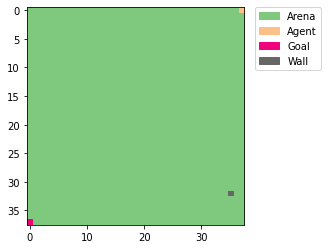

cumulative reward 54


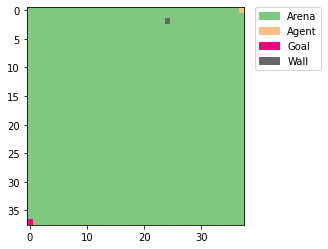

cumulative reward 54


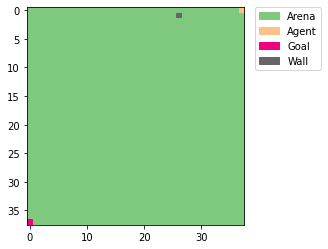

cumulative reward 54


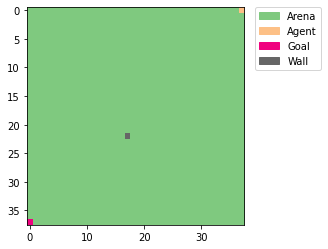

cumulative reward 54


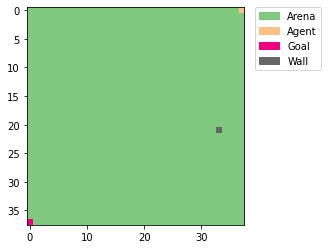

In [17]:
# Visualize some of the environments created
sum_reward = 0
n_step = 20
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

# Create environment

In [1]:
from utils import *
import gym

In [2]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v1 import Adversarial_v1

select_env = "adversarial-v1"
register_env(select_env, lambda config: Adversarial_v1())

In [3]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

import ray.rllib.agents.ppo as ppo

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-02 21:36:44,989	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-02 21:36:45,842	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-04-02 21:36:45,843	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-04-02 21:36:45,923	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-02 21:36:46,954	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-02 21:36:47,838	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-02 21:36:50,875	WARNING util.py:47 -- Install gputil for 

In [4]:
chkpt_root = "tmp/exa"
chkpt_file = chkpt_root + '/checkpoint_100/checkpoint-100'

#restore the latest saved checkpoint for the policy
agent.restore(chkpt_file)
#create our environment 
env = gym.make(select_env)
#reset its state
state = env.reset()

sum_reward = 0
n_step = 3
for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)    
    sum_reward += reward
    #env.render()    
    if done == True:
        print("cumulative reward", sum_reward)
        visualize(env.image_space) 
        state = env.reset()
        sum_reward = 0

2021-04-02 21:36:51,201	INFO trainable.py:372 -- Restored on 192.168.1.48 from checkpoint: tmp/exa/checkpoint_100/checkpoint-100
2021-04-02 21:36:51,202	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5047.39506316185, '_episodes_total': 100000}


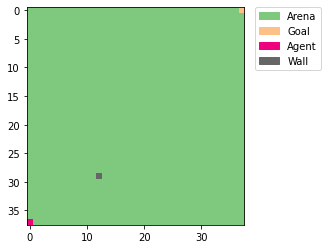

In [5]:
visualize(env.image_space) 

In [6]:
# padd with zeroes

matrix = np.zeros((40, 40))
# actually you can also use result = np.zeros_like(b) 
# but that also copies the dtype not only the shape

matrix[1:39,1:39] = env.image_space
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
my_config = matrix2arena(matrix)
#my_config.to_proto()

In [8]:
# visualize evironment just created

try:
    environment = AnimalAIEnvironment(
            file_name='../env/AnimalAI',
            base_port=5007,
            arenas_configurations=my_config,
            play=True,
            worker_id = 5,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

In [9]:
if environment:
    environment.close() # takes a few seconds

# Train Protagonist on this environment

In [10]:
trainer_config_path = (
    "../configurations/training_configurations/train_ml_agents_config_ppo_10fs.yaml"
)
reset_trainer(trainer_config_path, steps=1.0e4)

In [11]:
reward = train_protagonist(arena_config=my_config, trainer_config_path=trainer_config_path, base_port_protagonist=6002, load_model=False)

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0


In [8]:
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from mlagents.trainers.trainer_util import load_config;
from animalai_train.run_options_aai import RunOptionsAAI;
from animalai_train.run_training_aai import run_training_aai;

import os
import pandas as pd

In [9]:
def update_trainer(trainer_config_path, steps_add=1.0e5):
    with open(trainer_config_path) as f:
         list_doc = yaml.load(f)

    #list_doc['AnimalAI']['max_steps']  = 1.0e5
    list_doc['AnimalAI']['max_steps'] = float(list_doc['AnimalAI']['max_steps']) + steps_add

    with open(trainer_config_path, "w") as f:
        yaml.dump(list_doc, f)

In [10]:
def reset_trainer(trainer_config_path, steps=1.0e4):
    with open(trainer_config_path) as f:
         list_doc = yaml.load(f)

    #list_doc['AnimalAI']['max_steps']  = 1.0e5
    list_doc['AnimalAI']['max_steps'] = steps

    with open(trainer_config_path, "w") as f:
        yaml.dump(list_doc, f)

In [11]:
# define configurations
trainer_config_path = (
    "../configurations/training_configurations/train_ml_agents_config_ppo_10fs.yaml"
)
environment_path = "../env/AnimalAI"
run_id_protagonist = "protagonist"
base_port_protagonist = 5005
logs_dir = "summaries/"
os.makedirs(logs_dir, exist_ok=True)

In [12]:
reset_trainer(trainer_config_path)
with open(trainer_config_path) as f:
    print(f.read())

AnimalAI:
  batch_size: 64
  beta: 0.01
  buffer_size: 2024
  epsilon: 0.2
  hidden_units: 256
  lambd: 0.95
  learning_rate: 0.0003
  learning_rate_schedule: linear
  max_steps: 10000.0
  memory_size: 128
  normalize: false
  num_epoch: 3
  num_layers: 1
  reward_signals:
    curiosity:
      encoding_size: 256
      gamma: 0.99
      strength: 0.01
    extrinsic:
      gamma: 0.99
      strength: 1.0
  sequence_length: 64
  summary_freq: 10000
  time_horizon: 128
  trainer: ppo
  use_recurrent: false
  vis_encode_type: simple



In [53]:
args = RunOptionsAAI(
        trainer_config=load_config(trainer_config_path),
        env_path=environment_path,
        run_id=run_id_protagonist,
        base_port=base_port_protagonist + 1,
        load_model=False,
        train_model=True,
        arena_config=my_config 
    )
run_training_aai(0, args)
%load_ext tensorboard
%tensorboard --logdir {logs_dir}

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 71664), started 0:07:28 ago. (Use '!kill 71664' to kill it.)

In [54]:
data_path = 'summaries/protagonist_AnimalAI.csv'
df = pd.read_csv(data_path)
print('PROTAGONIST: ')
print('Steps: ', df.loc[0, 'Steps'], ' Cumulative reward: ', df.loc[0, 'Environment/Cumulative Reward'], \
 ' Episode Length: ', df.loc[0, 'Environment/Episode Length'])
print('Steps: ', df.loc[int(len(df)/2), 'Steps'], ' Cumulative reward: ', df.loc[int(len(df)/2), 'Environment/Cumulative Reward'], \
     ' Episode Length: ', df.loc[int(len(df)/2), 'Environment/Episode Length'])
print('Steps: ', df.loc[len(df)-1, 'Steps'], ' Cumulative reward: ', df.loc[len(df)-1, 'Environment/Cumulative Reward'], \
     ' Episode Length: ', df.loc[len(df)-1, 'Environment/Episode Length'])

PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0


In [13]:
def train_protagonist(arena_config, trainer_config_path, base_port_protagonist = 5005, run_id_protagonist = "protagonist", load_model = True):
    
    environment_path = "../env/AnimalAI"
    logs_dir = "summaries/"
    
    args = RunOptionsAAI(
        trainer_config=load_config(trainer_config_path),
        env_path=environment_path,
        run_id=run_id_protagonist,
        base_port=base_port_protagonist,
        load_model=load_model,
        train_model=True,
        arena_config=my_config 
    )
    run_training_aai(0, args)
    
    data_path = 'summaries/' + run_id_protagonist + '_AnimalAI.csv'
    df = pd.read_csv(data_path)
    print('PROTAGONIST: ')
    print('Steps: ', df.loc[0, 'Steps'], ' Cumulative reward: ', df.loc[0, 'Environment/Cumulative Reward'], \
     ' Episode Length: ', df.loc[0, 'Environment/Episode Length'])
    print('Steps: ', df.loc[int(len(df)/2), 'Steps'], ' Cumulative reward: ', df.loc[int(len(df)/2), 'Environment/Cumulative Reward'], \
         ' Episode Length: ', df.loc[int(len(df)/2), 'Environment/Episode Length'])
    print('Steps: ', df.loc[len(df)-1, 'Steps'], ' Cumulative reward: ', df.loc[len(df)-1, 'Environment/Cumulative Reward'], \
         ' Episode Length: ', df.loc[len(df)-1, 'Environment/Episode Length'])
    
    return df.loc[len(df)-1, 'Environment/Cumulative Reward']
    

In [14]:
reward = train_protagonist(arena_config=my_config, base_port_protagonist=6002, load_model=False)

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0


In [17]:
reward

-0.9999999310821296